In [16]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt

device = 'cuda'

def norm(vec):
    return torch.nn.functional.normalize(vec, p=2, dim=1)


def mag(vec):
    return vec.norm(p=2, dim=1, keepdim=True)


def plot(trainer):
    figure, axes = plt.subplots()
    uc_3 = plt.Circle(trainer.c, trainer.R, fill=False)

    new_x = []
    new_y = []

    for data in transformed_data:
        map = dsvdd.forward(torch.nn.functional.normalize(data, p=2, dim=0)).cpu().detach().numpy()
        new_x.append(map[0])
        new_y.append(map[1])

    #print(mixin_training[-10:])
    anomalous = transformed_data[0].cpu().detach().numpy()
    #
    anomalous[0] = random.random() * -20
    anomalous[1] = random.random() * -15

    an_x = []
    an_y = []
    for outlier in t_outlier_data:
        outlier_pos = dsvdd.forward(torch.nn.functional.normalize(outlier, p=2, dim=0)).cpu().detach().numpy()
        an_x.append(outlier_pos[0])
        an_y.append(outlier_pos[1])

    anomalous = torch.tensor(anomalous, dtype=torch.float32, device=device)
    an = dsvdd.forward(torch.nn.functional.normalize(anomalous, p=2, dim=0)).cpu().detach().numpy()
    center = dsvdd_trainer.c.cpu().detach().numpy()
    points_2 = plt.scatter(new_x, new_y,
                           color="green", s=5, label="Normal Class")
    plt.scatter(center[0], center[1],
                color="blue", s=5)
    axes.add_artist(uc_3)
    plt.gca().add_patch(uc_3)
    plt.axis('equal')
    plt.show()

plt.rcParams.update(plt.rcParamsDefault)
torch.manual_seed(42)

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            nn.Linear(20, 20, bias=False),
            nn.LeakyReLU(),
            nn.Linear(20, 10, bias=False),
            nn.LeakyReLU(),
            nn.Linear(10, 2, bias=False),
            nn.LeakyReLU(),
            nn.Linear(2, 10, bias=False),
            nn.LeakyReLU(),
            nn.Linear(10, 20, bias=False),
            nn.LeakyReLU(),
            nn.Linear(20, 20, bias=False)
        ).to(device)

    def forward(self, x):
        return self.layers(x)


class AETrainer():
    def __init__(self, model):
        self.model = model

    def train(self, training_data):
        train_loader = torch.utils.data.DataLoader(list(zip(training_data, training_data)), batch_size=1, shuffle=True)
        loss_function = nn.L1Loss(reduction='sum').to(device)
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001)
        losses = []
        for epoch in range(0, 30):
            epoch_loss = []
            for i, data in enumerate(train_loader, 0):
                inputs, targets = data
                optimizer.zero_grad()
                inputs = norm(inputs)
                targets = torch.nn.functional.normalize(targets, p=2, dim=1)
                outputs = self.model(inputs)
                loss = loss_function(outputs, targets) * loss_function(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss.append(loss.item())
            losses.append(sum(epoch_loss) / len(epoch_loss))
        return losses

    def model(self):
        return self.model()


X = (5, 10)
Y = (20, 25)


def my_plot(epochs, loss):
    plt.plot(epochs, loss)

# Create basic training data for 

training_samples = []
validation_data = []
outlier_data_set = []
for i in range(1000):
    training_samples.append([random.uniform(X[0], X[1]), random.uniform(Y[0], Y[1])])

transformed_data = []
t_validation_data = []
t_outlier_data = []

for i in range(200):
    validation_data.append([random.uniform(X[0], X[1]), random.uniform(Y[0], Y[1])])

for i in range(300):
    outlier_data_set.append([random.uniform(17, 19), random.uniform(28, 29)])

for i in range(300):
    outlier_data_set.append([random.uniform(3, 4), random.uniform(17, 19)])

for i in range(0, 1000, 10):
    sample = training_samples[i:i + 10]
    t_data = []
    for x, y in sample:
        t_data.append(x)
        t_data.append(y)
    transformed_data.append(t_data)

for i in range(0, 200, 10):
    sample = validation_data[i:i + 10]
    t_data = []
    for x, y in sample:
        t_data.append(x)
        t_data.append(y)
    t_validation_data.append(t_data)

for i in range(0, 600, 10):
    sample = outlier_data_set[i:i + 10]
    t_data = []
    for x, y in sample:
        t_data.append(x)
        t_data.append(y)
    t_outlier_data.append(t_data)

# Build data sets
mixin_training = transformed_data + t_outlier_data
transformed_data = torch.tensor(transformed_data, dtype=torch.float32).to(device)
t_validation_data = torch.tensor(t_validation_data, dtype=torch.float32).to(device)
t_outlier_data = torch.tensor(t_outlier_data, dtype=torch.float32).to(device)
mixin_training = torch.tensor(mixin_training, dtype=torch.float32).to(device)

ae = AutoEncoder()
ae_trainer = AETrainer(ae)
losses = ae_trainer.train(transformed_data)
my_plot(np.linspace(1, 30, 30).astype(int), losses)
b = transformed_data[0]



a = ae.forward(torch.nn.functional.normalize(transformed_data[0], p=2, dim=0))
print(a)
print(a * transformed_data[0].norm(p=2, dim=0, keepdim=True))

second_x = []
second_y = []
for d in transformed_data:
    s = ae.forward(torch.nn.functional.normalize(d, p=2, dim=0)).cpu().detach()
    s = s * d.norm(p=2, dim=0, keepdim=True).cpu()
    print(s)
    for i in range(0, 20, 2):
        second_x.append(s[i])
        second_y.append(s[i + 1])



tensor([0.1062, 0.2996, 0.1024, 0.2989, 0.1039, 0.3026, 0.1021, 0.3031, 0.0989,
        0.3026, 0.1010, 0.3057, 0.0936, 0.2999, 0.0962, 0.3015, 0.1065, 0.3026,
        0.1045, 0.3005], device='cuda:0', grad_fn=<SqueezeBackward4>)
tensor([ 8.0991, 22.8568,  7.8145, 22.8016,  7.9220, 23.0796,  7.7854, 23.1227,
         7.5407, 23.0797,  7.7048, 23.3209,  7.1408, 22.8802,  7.3364, 22.9955,
         8.1251, 23.0833,  7.9725, 22.9251], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([ 8.0991, 22.8568,  7.8145, 22.8016,  7.9220, 23.0796,  7.7854, 23.1227,
         7.5407, 23.0797,  7.7048, 23.3209,  7.1408, 22.8802,  7.3364, 22.9955,
         8.1251, 23.0833,  7.9725, 22.9251])
tensor([ 8.0482, 22.6982,  7.7621, 22.6420,  7.8707, 22.9254,  7.7338, 22.9654,
         7.4934, 22.9285,  7.6576, 23.1594,  7.0912, 22.7264,  7.2815, 22.8332,
         8.0708, 22.9239,  7.9250, 22.7717])
tensor([ 7.9815, 22.5363,  7.7035, 22.4829,  7.8081, 22.7514,  7.6743, 22.7960,
         7.4312, 22.7492,  

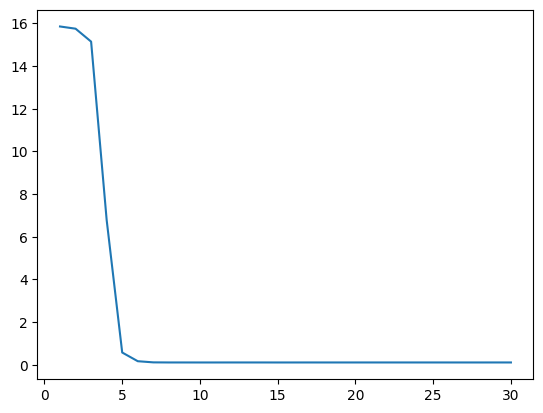

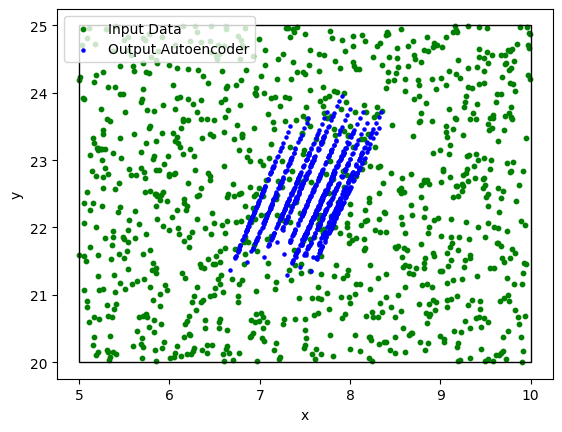

In [18]:
figure, axes = plt.subplots()
#axes.set(xlim=(5, 10), ylim=(20, 25))
uc_3 = plt.Rectangle((5, 20), 5, 5, fill=False)
new_x = []
new_y = []
for z in training_samples:
    new_x.append(z[0])
    new_y.append(z[1])
points_1 = plt.scatter(new_x,
                       new_y,
                       color="green", s=10, label="Input Data")
points_2 = plt.scatter(second_x, second_y,
                       color="blue", s=5, label="Output Autoencoder")
axes.add_artist(uc_3)
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.legend()
plt.show()

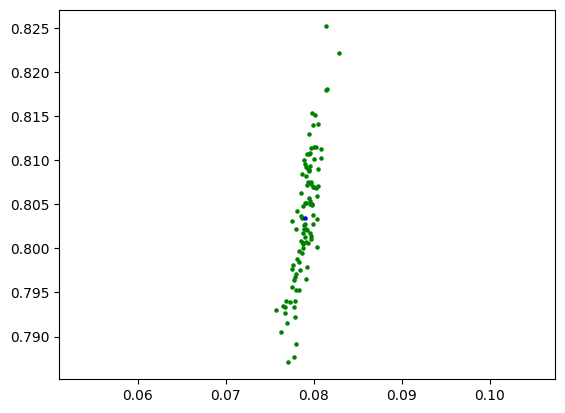

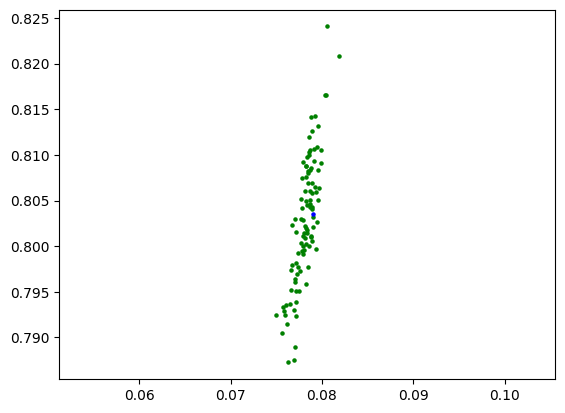

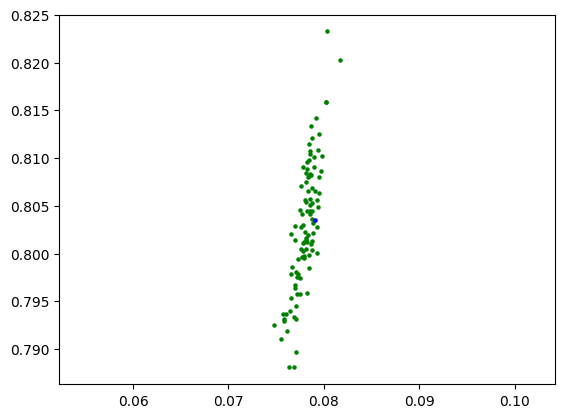

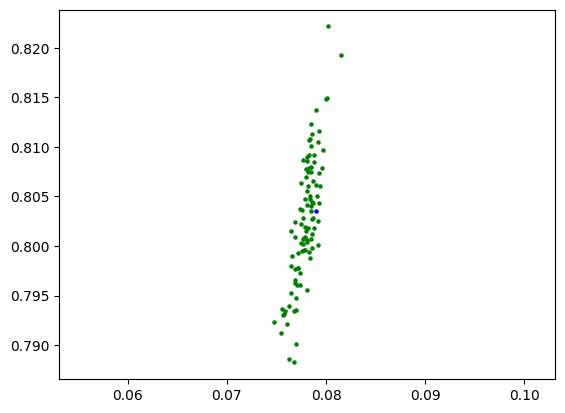

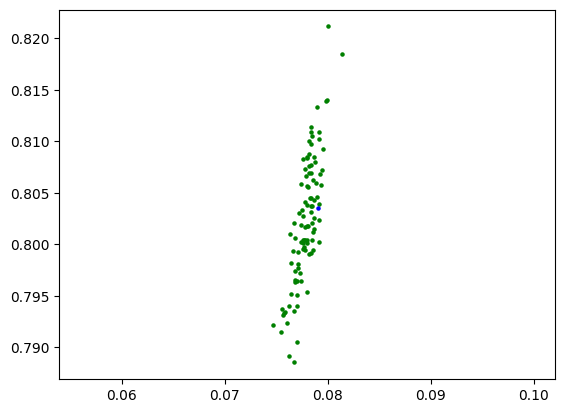

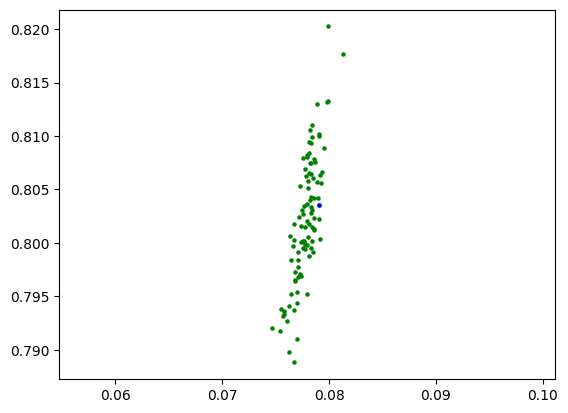

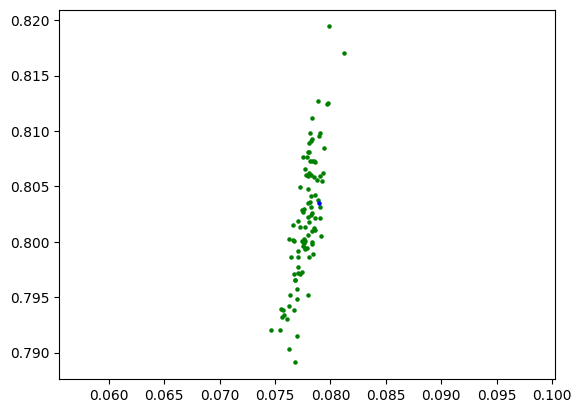

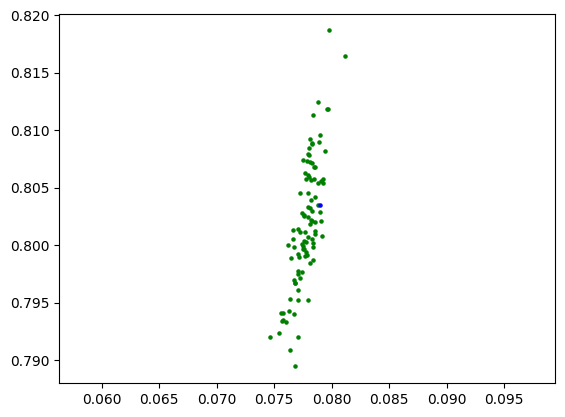

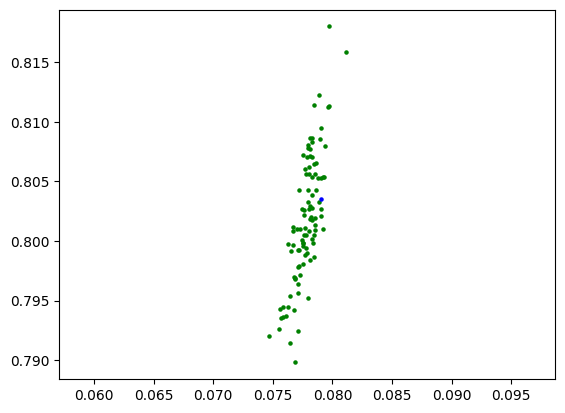

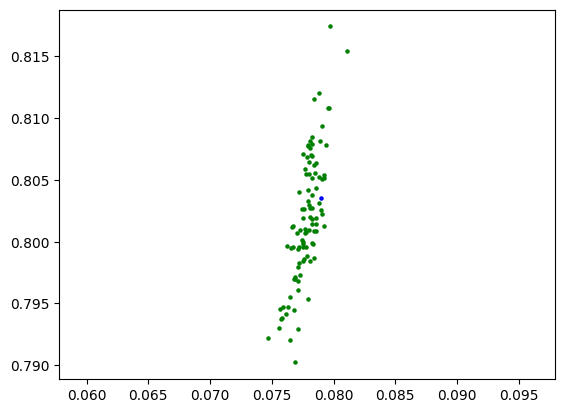

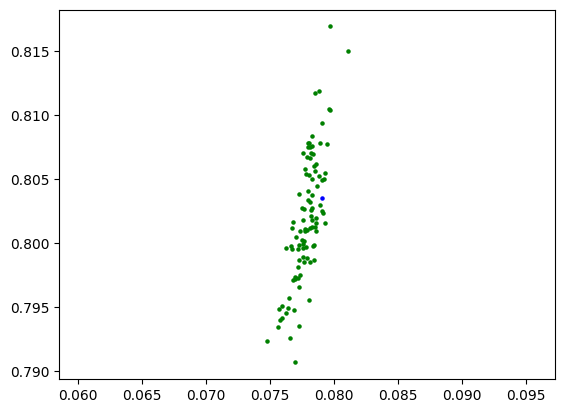

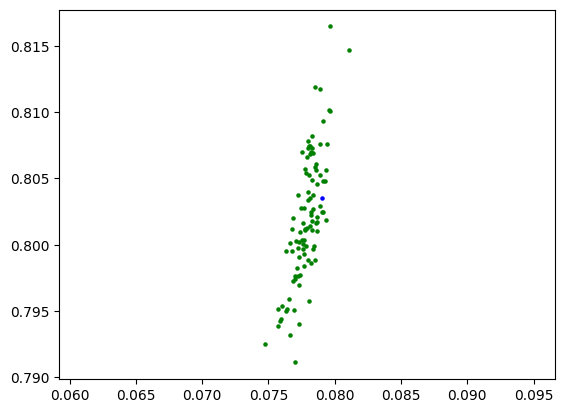

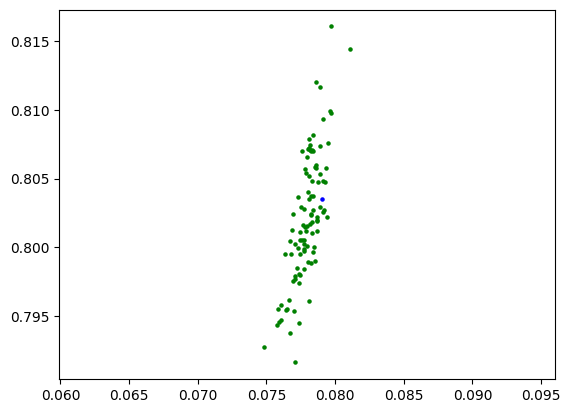

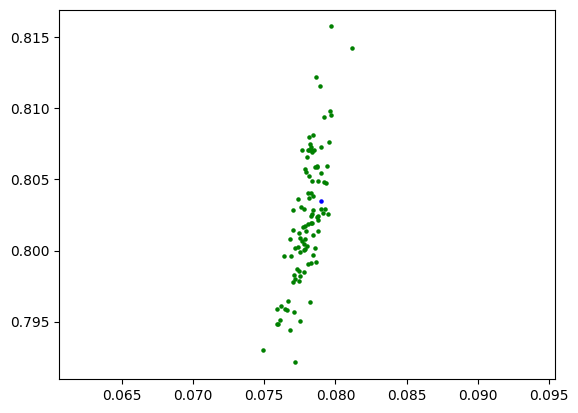

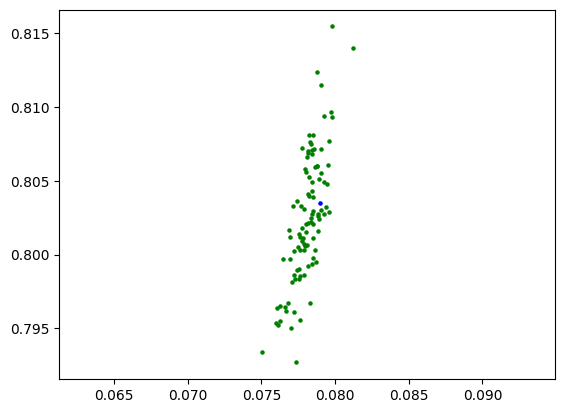

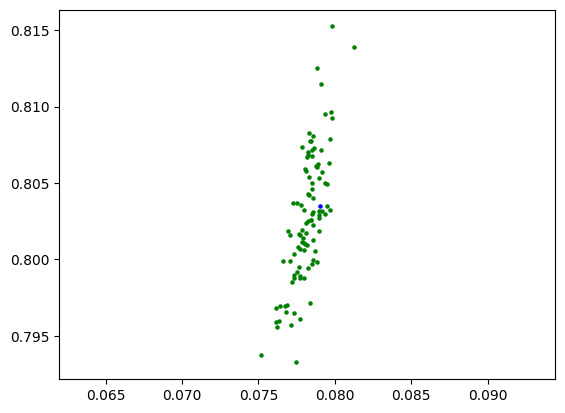

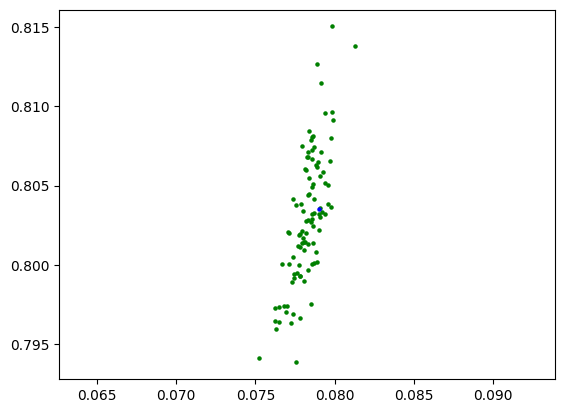

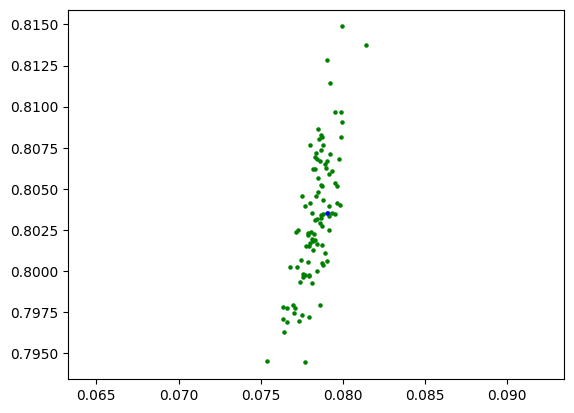

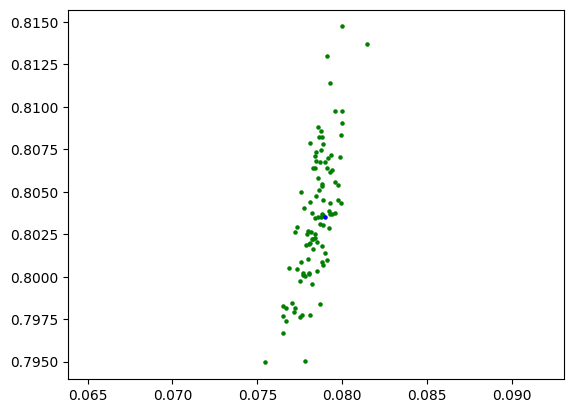

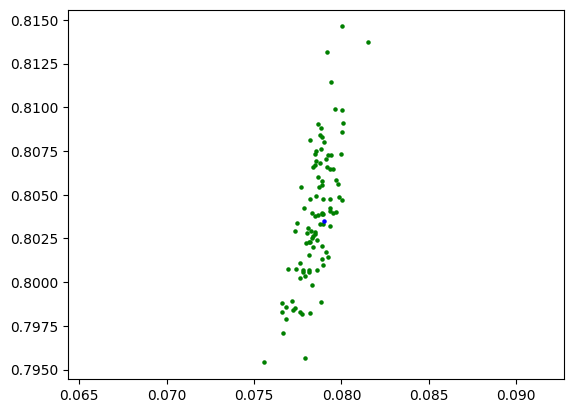

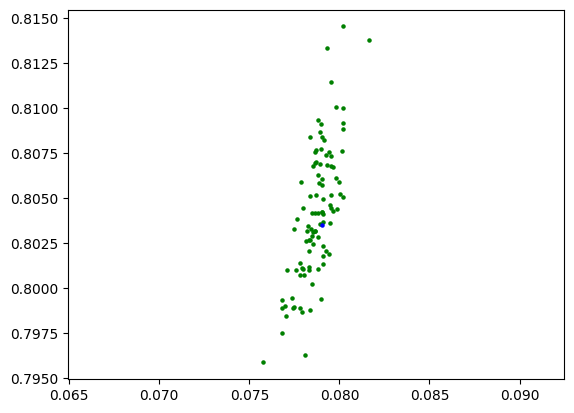

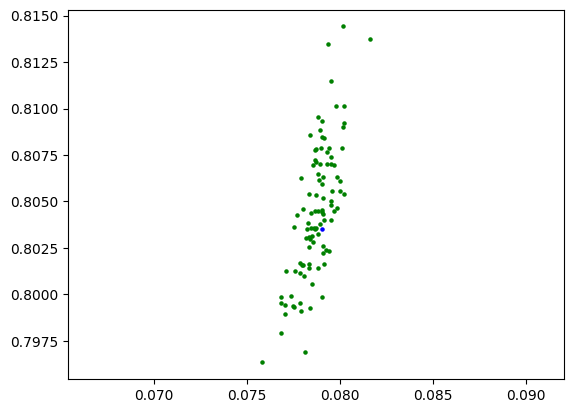

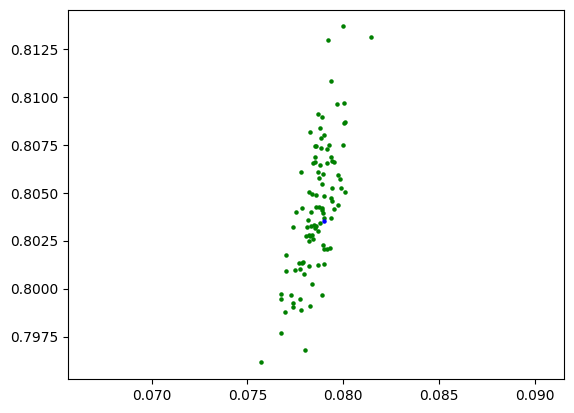

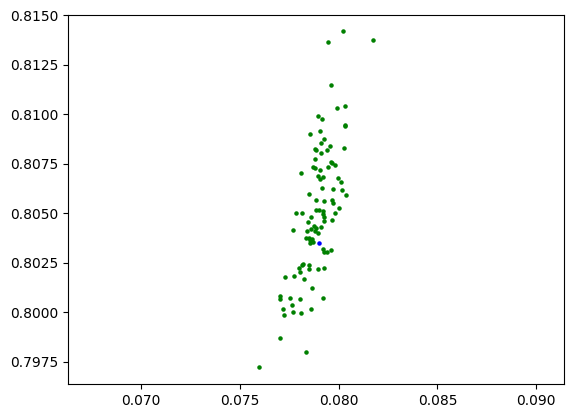

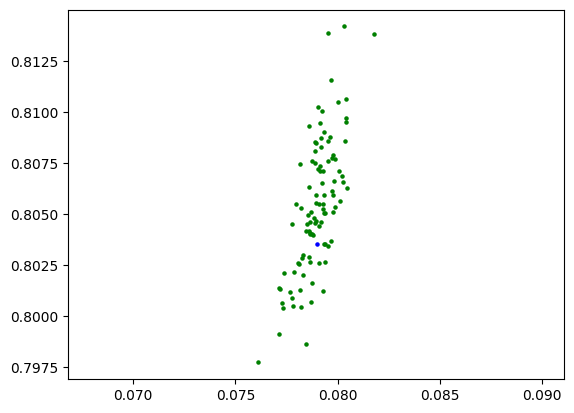

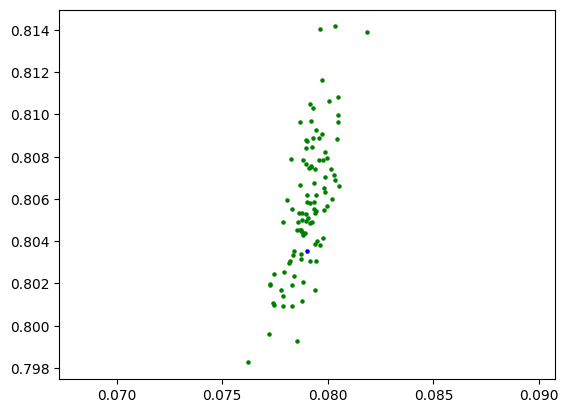

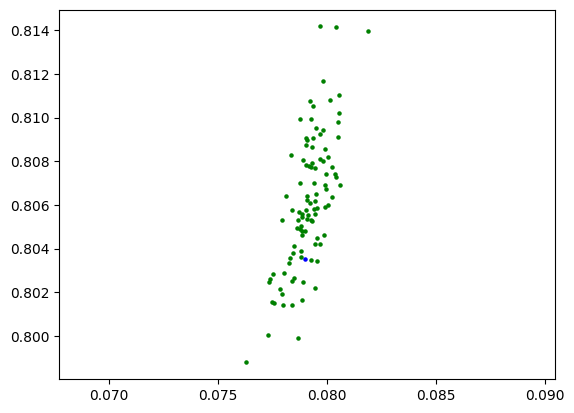

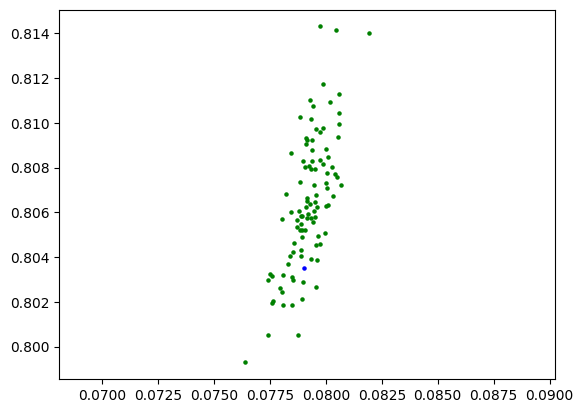

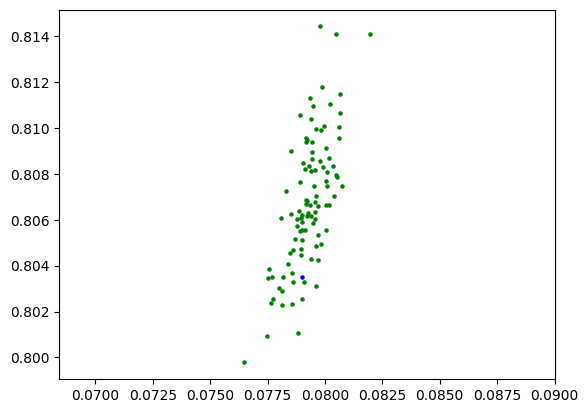

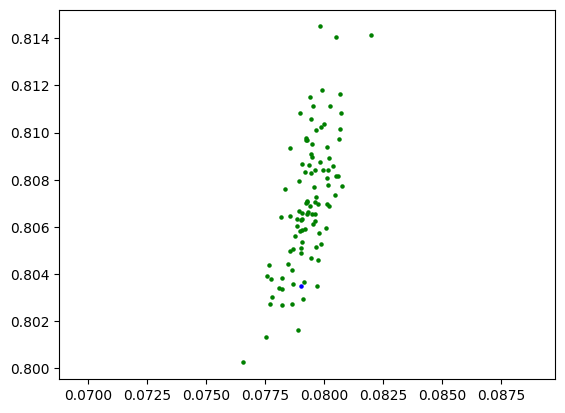

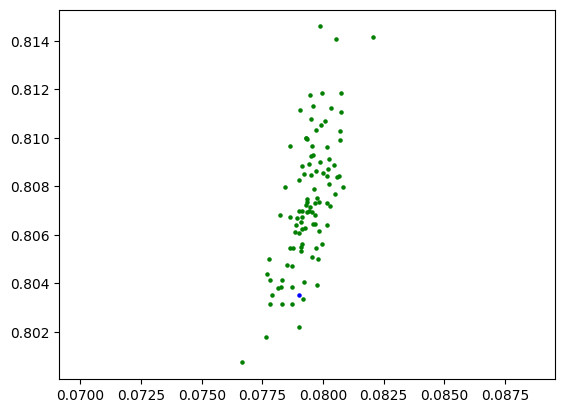

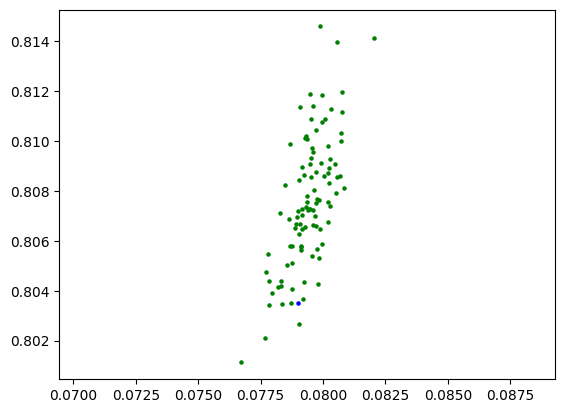

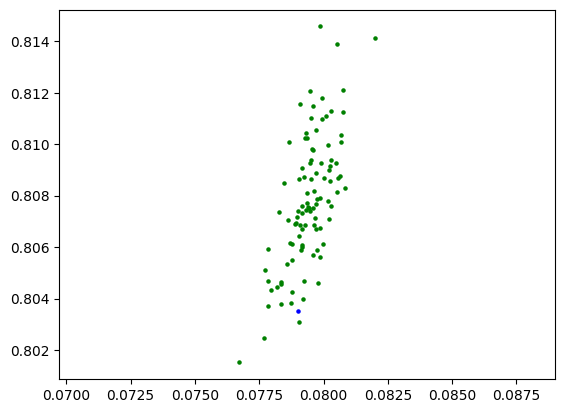

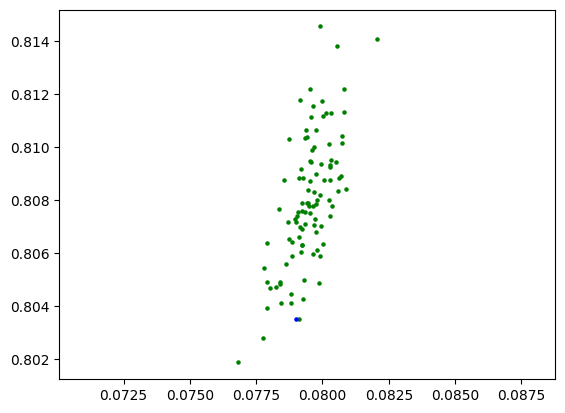

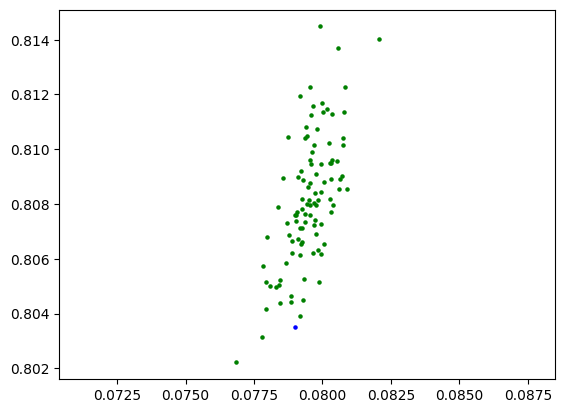

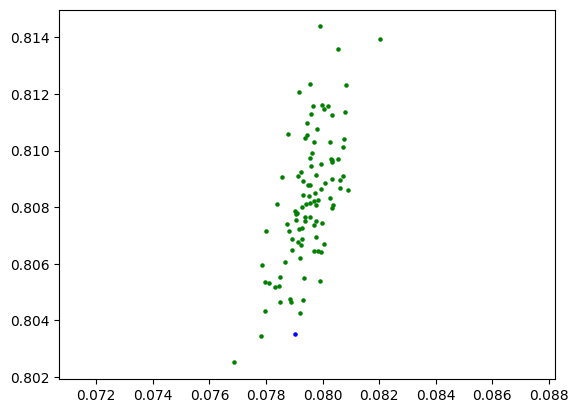

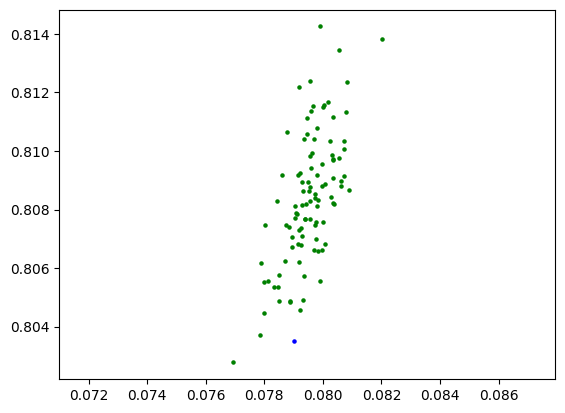

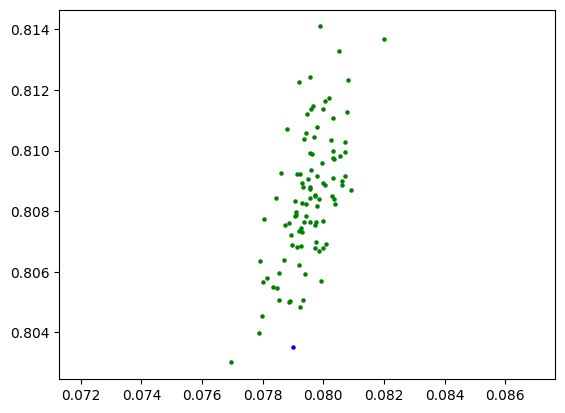

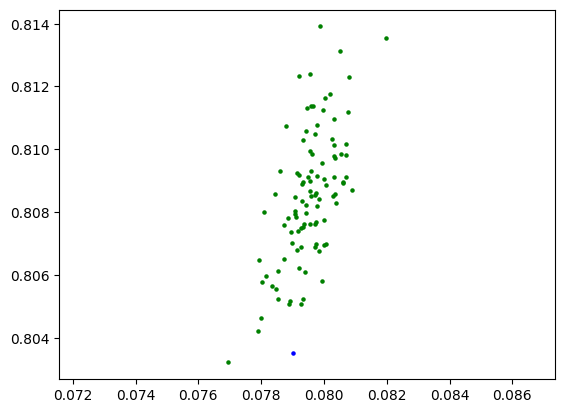

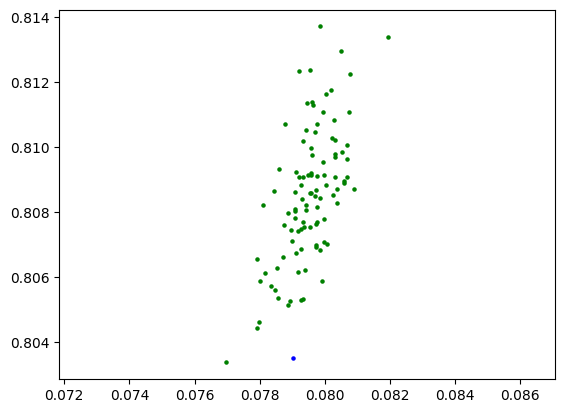

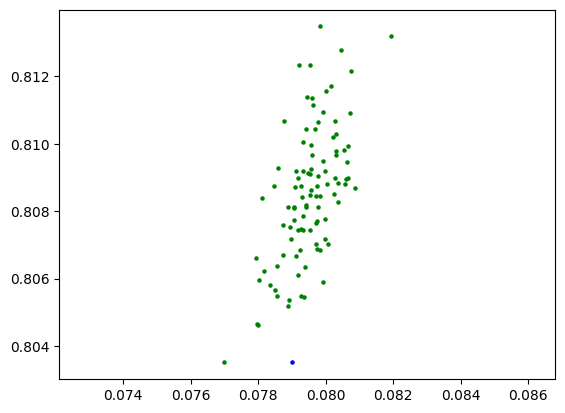

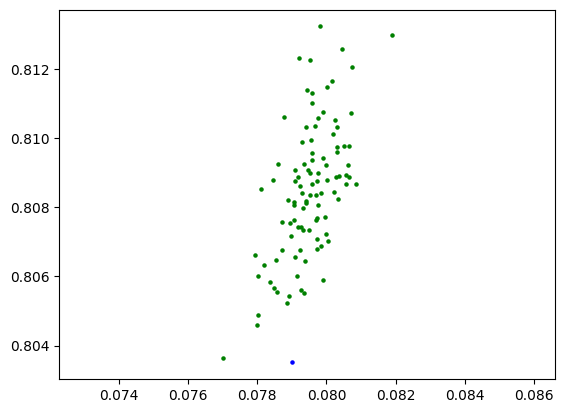

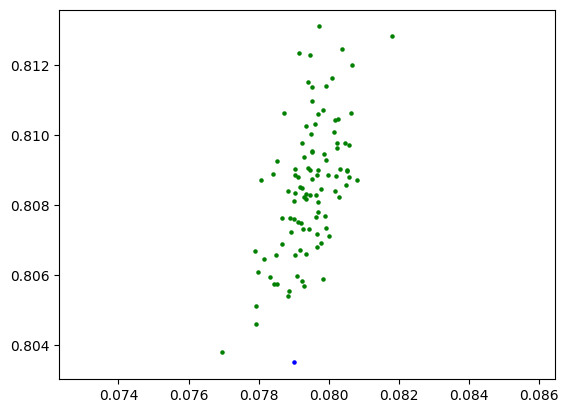

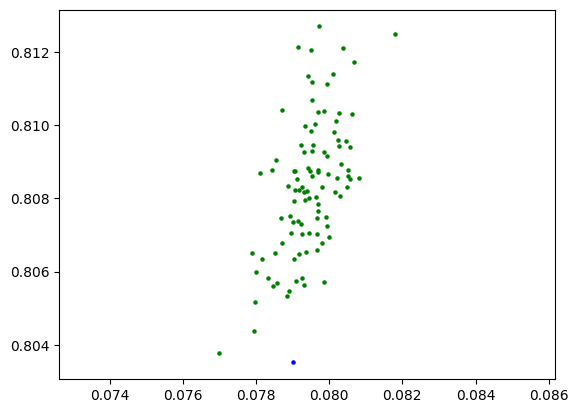

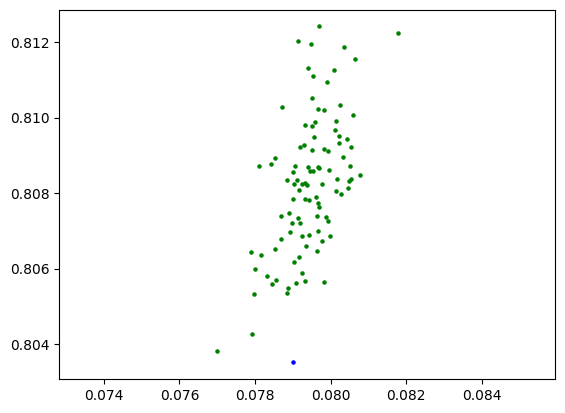

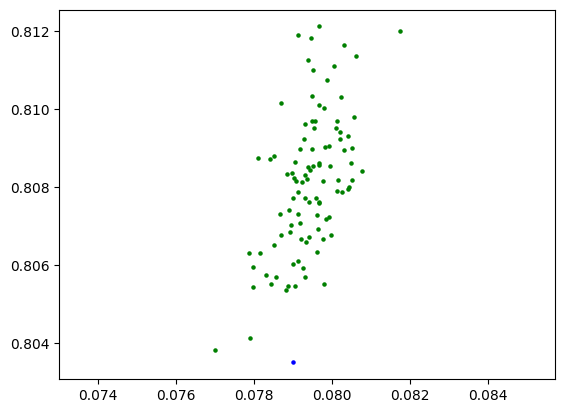

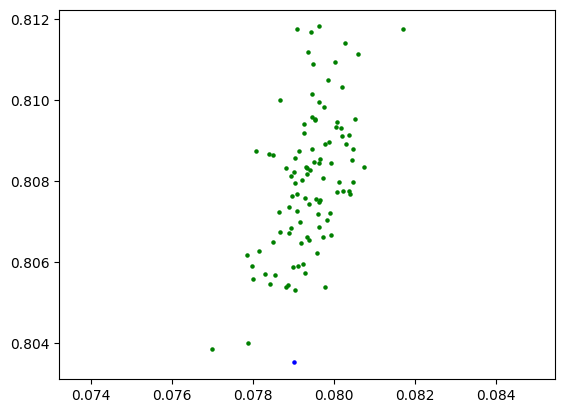

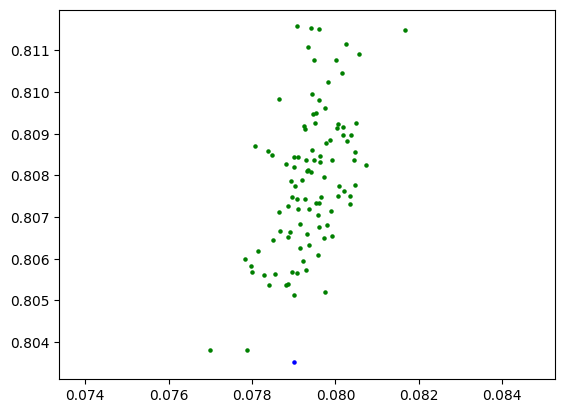

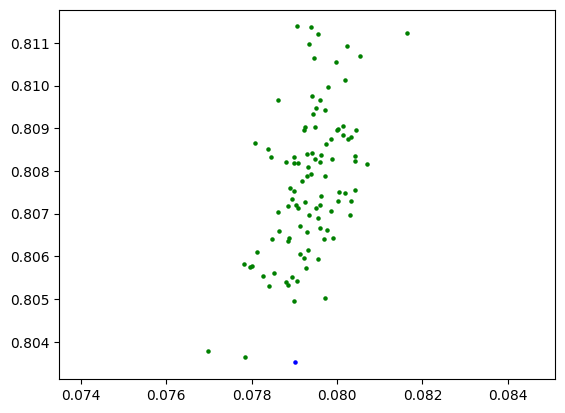

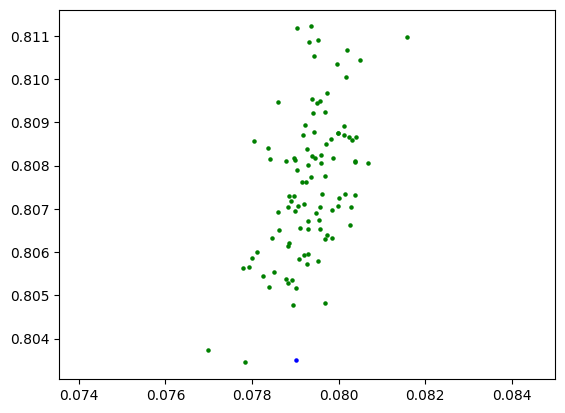

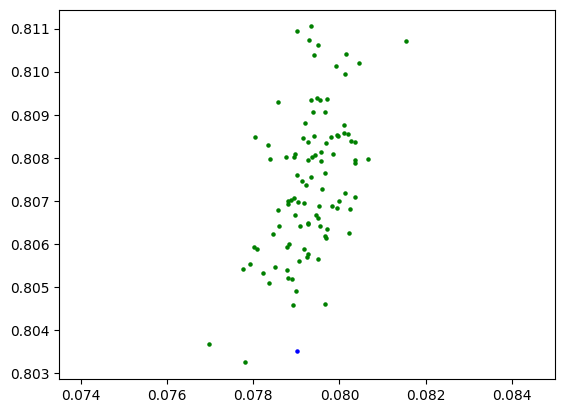

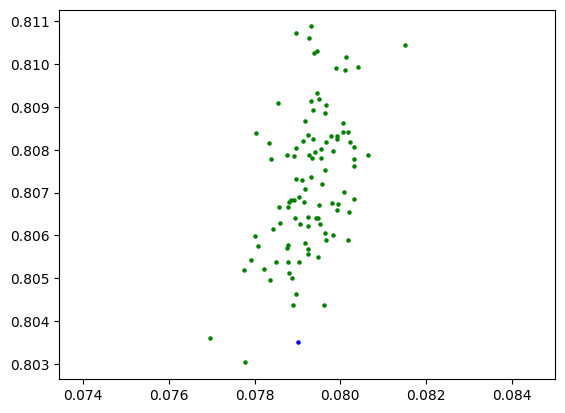

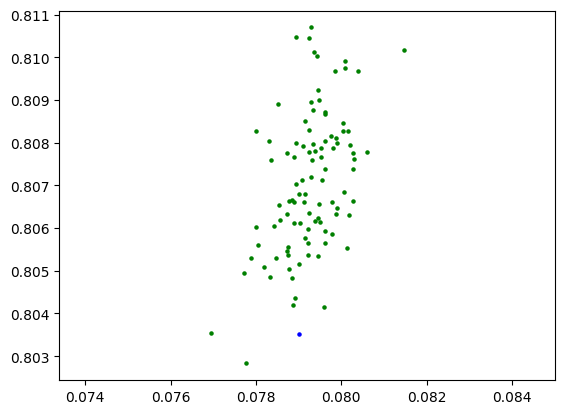

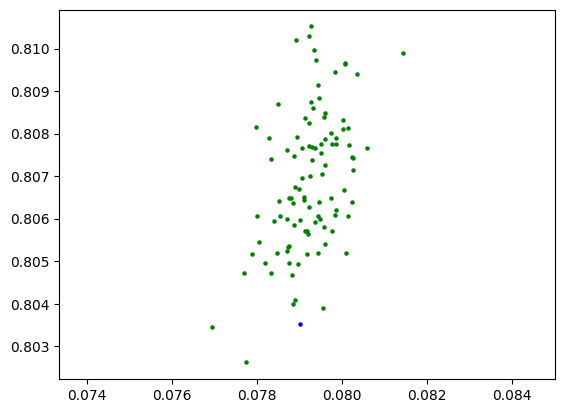

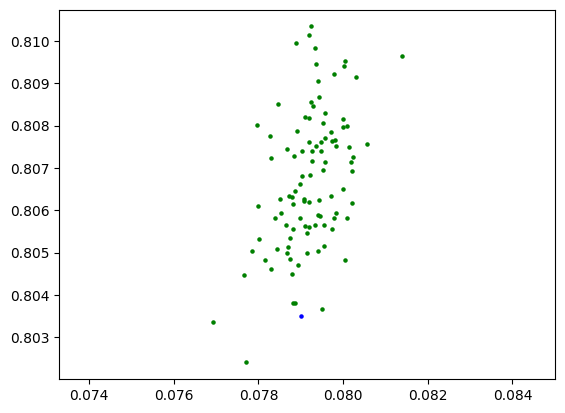

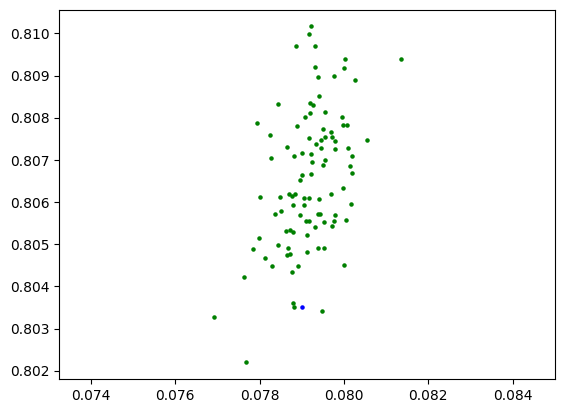

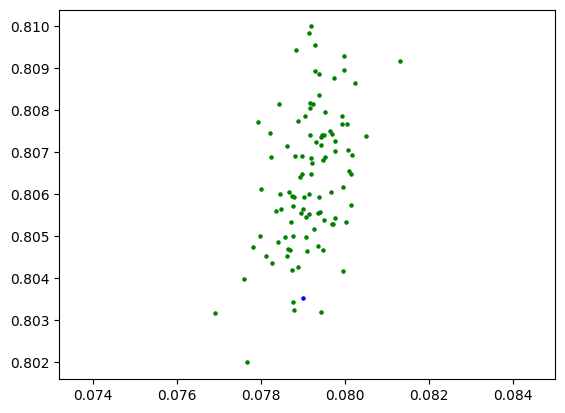

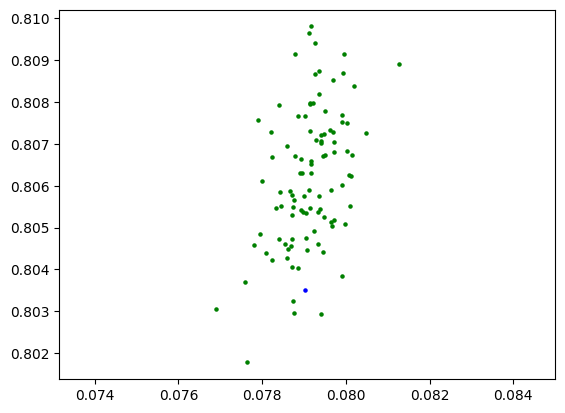

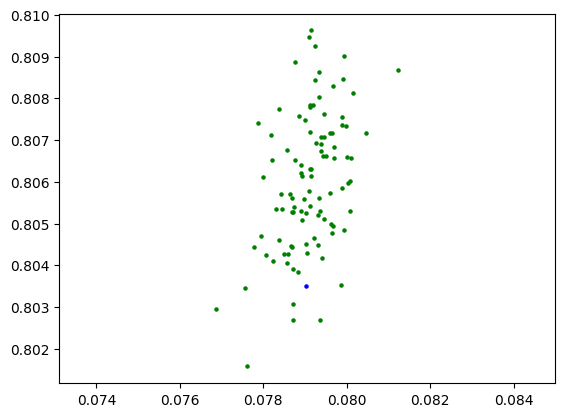

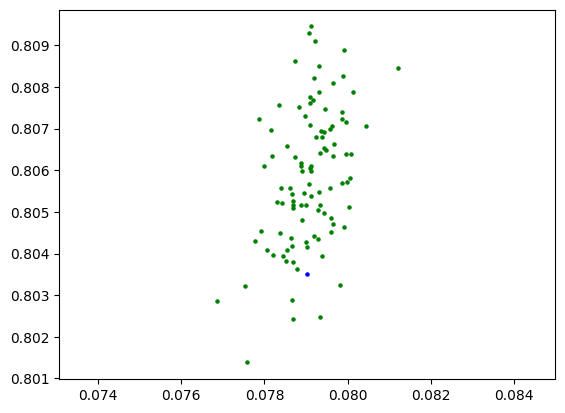

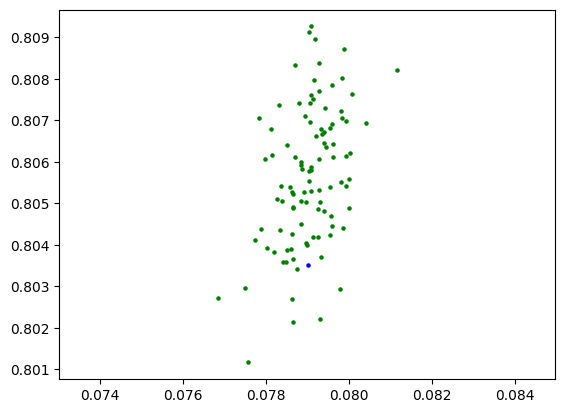

[0.00011086344563452144,
 7.900308734804185e-05,
 7.59703042713511e-05,
 7.084994609302342e-05,
 6.56975594506548e-05,
 6.086682969179691e-05,
 5.641461110396761e-05,
 5.2344122412222305e-05,
 4.859849247253578e-05,
 4.521996278199936e-05,
 4.215003854895372e-05,
 3.93832616177292e-05,
 3.690839750817077e-05,
 3.4678485812946745e-05,
 3.2672454187689935e-05,
 3.0886459156747036e-05,
 2.9286211254344608e-05,
 2.784696892866201e-05,
 2.654543308263868e-05,
 2.639051537340009e-05,
 2.423650923816467e-05,
 2.560634081969937e-05,
 2.1787312802594716e-05,
 2.1413889616335167e-05,
 2.0628062794170176e-05,
 1.989521587802301e-05,
 1.9211029684953473e-05,
 1.856911905974812e-05,
 1.796571887638265e-05,
 1.740790366184797e-05,
 1.6894372874354248e-05,
 1.6344410474120607e-05,
 1.5873283695384542e-05,
 1.541800798921855e-05,
 1.4974650482706408e-05,
 1.4550171583014305e-05,
 1.4143867269140741e-05,
 1.375528497906453e-05,
 1.3383944928495595e-05,
 1.3030437338557022e-05,
 1.2693740116063168e-05,


In [19]:
from numpy import sqrt, quantile


class DeepSVDD(nn.Module):
    def __init__(self, autoencoder):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(20, 20, bias=False),
            nn.LeakyReLU(),
            nn.Linear(20, 10, bias=False),
            nn.LeakyReLU(),
            nn.Linear(10, 2, bias=False)
        ).to(device)
        net_dict = self.state_dict()
        ae_dict = ae.state_dict()
        ae_dict = {k: v for k, v in ae_dict.items() if k in net_dict}
        net_dict.update(ae_dict)
        self.load_state_dict(net_dict)

    def forward(self, x):
        return self.layers(x)


# Trainer can train models for either soft-boundary Deep SVDD or One-Class Deep SVDD
class DeepSVDDTrainer:
    def __init__(self, model, goal, c_size):
        self.model = model
        self.goal = goal
        self.c = torch.tensor([0, 0], dtype=torch.float32, device=device)
        self.R = torch.tensor(0, dtype=torch.float32, device=device)

    def train(self, training_data):
        optimizer = torch.optim.Adam(dsvdd.parameters(), lr=0.001)
        train_loader = torch.utils.data.DataLoader(list(zip(training_data, training_data)), batch_size=1)
        warmup_epoch = 5
        nu = 0.1

        losses = []

        for epoch in range(60):
            epoch_loss = []
            keks = []
            for data in train_loader:
                inputs, targets = data
                optimizer.zero_grad()
                outputs = dsvdd.forward(norm(inputs))
                dist = torch.sum((outputs - self.c) ** 2, dim=1)
                keks.append(dist.item())
                if self.goal == 'one-class':
                    loss = torch.mean(dist)
                else:
                    scores = dist - self.R ** 2
                    loss = self.R ** 2 + (1 / nu) * torch.mean(torch.max(torch.zeros_like(scores), scores))
                loss.backward()
                optimizer.step()
                epoch_loss.append(loss.item())

            if epoch >= warmup_epoch and self.goal == 'soft-boundary':
                self.R = torch.tensor(quantile(sqrt(keks), 1 - nu))
            losses.append(sum(epoch_loss) / len(epoch_loss))
            plot(self)
        
        if self.goal == 'one-class':
            dists = dsvdd.forward(norm(training_data)) - self.c
            dists = dists ** 2
            self.R = torch.quantile(torch.sum(dists, dim=1).sqrt(), 1 - nu)
        return losses

    def set_center(self, transformed_data):
        with torch.no_grad():
            self.c = torch.zeros(2, device='cuda')
            for x in transformed_data:
                self.c += dsvdd.forward(torch.nn.functional.normalize(x, p=2, dim=0))
            self.c /= len(transformed_data)


dsvdd = DeepSVDD(ae)
dsvdd_trainer = DeepSVDDTrainer(dsvdd, 'one-class', 2)
dsvdd_trainer.set_center(transformed_data)
plot(dsvdd_trainer)
dsvdd_trainer.train(transformed_data)

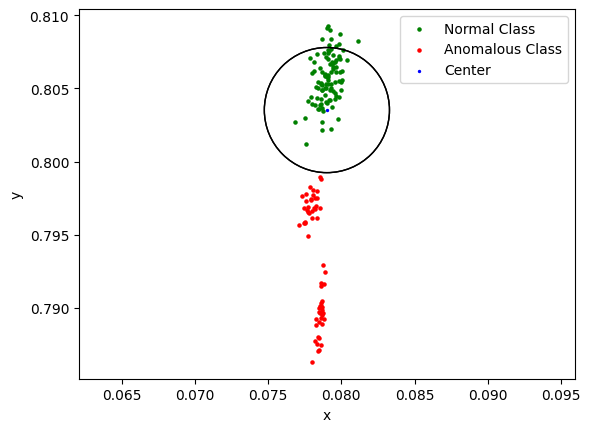

In [22]:
figure, axes = plt.subplots()
uc_3 = plt.Circle(dsvdd_trainer.c, dsvdd_trainer.R, fill=False)

new_x = []
new_y = []

for data in transformed_data:
    map = dsvdd.forward(torch.nn.functional.normalize(data, p=2, dim=0)).cpu().detach().numpy()
    new_x.append(map[0])
    new_y.append(map[1])

#print(mixin_training[-10:])
anomalous = transformed_data[0].cpu().detach().numpy()
#
anomalous[0] = random.random() * -20
anomalous[1] = random.random() * -15

an_x = []
an_y = []
for outlier in t_outlier_data:
    outlier_pos = dsvdd.forward(torch.nn.functional.normalize(outlier, p=2, dim=0)).cpu().detach().numpy()
    an_x.append(outlier_pos[0])
    an_y.append(outlier_pos[1])

anomalous = torch.tensor(anomalous, dtype=torch.float32, device=device)
an = dsvdd.forward(torch.nn.functional.normalize(anomalous, p=2, dim=0)).cpu().detach().numpy()
center = dsvdd_trainer.c.cpu().detach().numpy()
points_2 = plt.scatter(new_x, new_y,
                       color="green", s=5, label="Normal Class")
plt.scatter(an_x, an_y,
            color="red", s=5, label="Anomalous Class")
plt.scatter(center[0], center[1],
            color="blue", s=2, label="Center")
axes.add_artist(uc_3)
plt.gca().add_patch(uc_3)
plt.axis('equal')
axes.legend()
axes.set_xlabel("x")
axes.set_ylabel("y")
plt.show()


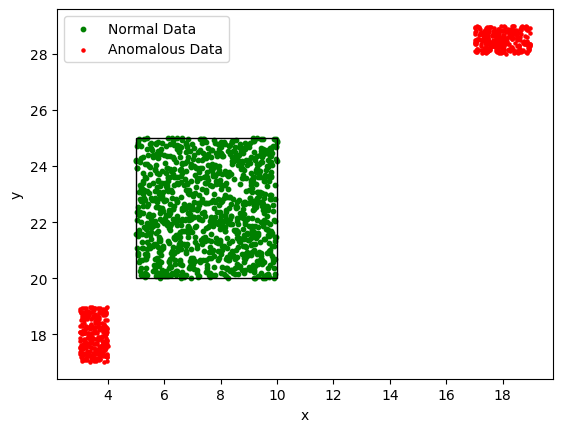

In [21]:
figure, axes = plt.subplots()
#axes.set(xlim=(5, 10), ylim=(20, 25))
uc_3 = plt.Rectangle((5, 20), 5, 5, fill=False)
new_x = []
new_y = []
for z in training_samples:
    new_x.append(z[0])
    new_y.append(z[1])

anormal_x = []
anormal_y = []

for x,y in outlier_data_set:
    anormal_y.append(y)
    anormal_x.append(x)
    
points_1 = plt.scatter(new_x,
                       new_y,
                       color="green", s=10, label="Normal Data")
points_2 = plt.scatter(anormal_x, anormal_y,
                       color="red", s=5, label="Anomalous Data")
axes.add_artist(uc_3)
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.legend()
plt.show()
